# 1. Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform
import random
import pyclustertend 
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import cluster

df = pd.read_csv('data/movies_2026.csv', encoding='latin1')
print(df.shape)

(19883, 28)


### 1.1 Preprocesamiento

Variables descartadas y razón:
- id             -> identificador único, no aporta patrón
- originalTitle, title -> texto libre, no numérico
- homePage       -> url, no aporta
- director, actors, actorsCharacter -> texto, alta cardinalidad
- actorsPopularity -> string con pipes, requeriría ingeniería extra
- genres, productionCompany, productionCompanyCountry, productionCountry -> categóricas multi-valor con pipes
- originalLanguage -> categórica de alta cardinalidad; se puede incluir como frecuencia si se desea
- releaseDate    -> reemplazada por releaseYear
- video          -> binario con pocos valores útiles para separar grupos

In [2]:
num_vars = ['popularity', 'budget', 'revenue', 'runtime',
            'voteAvg', 'voteCount', 'genresAmount',
            'productionCoAmount', 'productionCountriesAmount',
            'actorsAmount', 'castWomenAmount', 'castMenAmount',
            'releaseYear']

df_cluster = df[num_vars].copy()

# Eliminamos filas con nulos en estas variables
df_cluster.dropna(inplace=True)
print(df_cluster.shape)

# Normalizar datos
scaler = StandardScaler()
X = scaler.fit_transform(df_cluster)

(19719, 13)


### 1.2 Estadístico de Hopkins y VAT

Hopkins
- H ~ 0 -> agrupamiento fuerte
- H ~ 0.5 -> distribución aleatoria
- H ~ 1 -> distribución uniforme (grid)

VAT - por el tamaño del dataset (19k+ filas) se usa una muestra de 500

Estadística de Hopkins: 0.01317933546737622


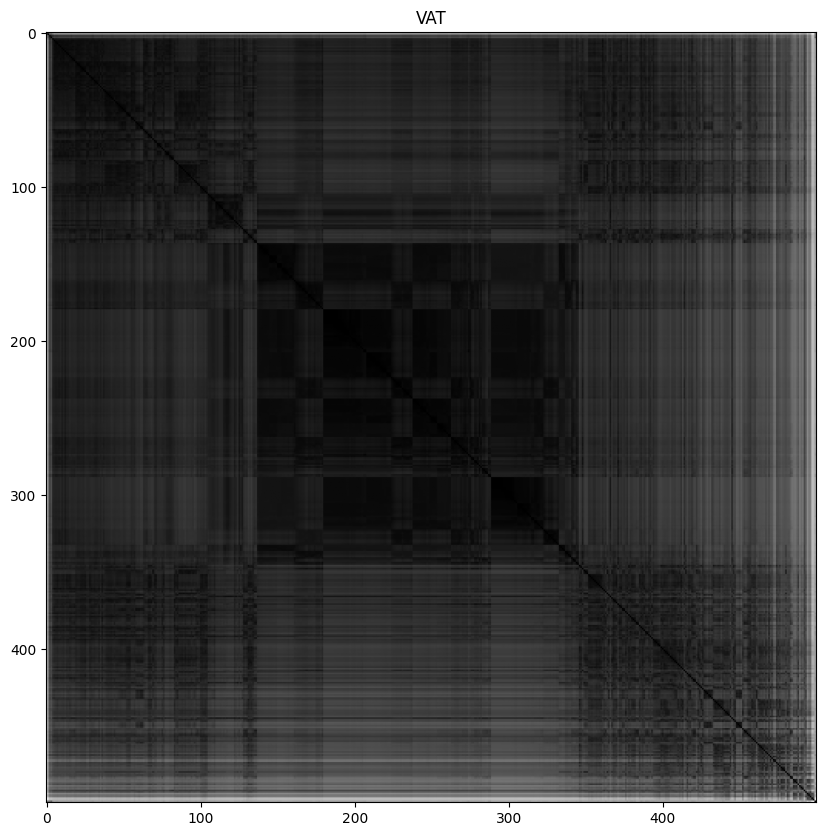

In [3]:
random.seed(123)

# Calcular la estadística de Hopkins
hopkins_stat = pyclustertend.hopkins(X, len(X))
print(f'Estadística de Hopkins: {hopkins_stat}')

# Calcular VAT
np.random.seed(123)
idx_vat = np.random.choice(len(X), 500, replace=False)
pyclustertend.vat(X[idx_vat])
plt.title('VAT')
plt.show()

### 1.3 Número óptimo de clusters - Gráfica de codo


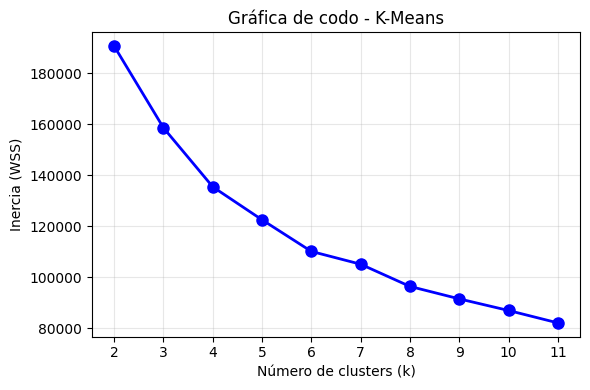

In [ ]:
inertias = []
k_range = range(2, 12)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(list(k_range), inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (WSS)')
plt.title('Gráfica de codo - K-Means')
plt.xticks(list(k_range))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 1.4 K-Means y Clustering Jerárquico

Distribución de clusters K-Means:
cluster_kmeans
0    9624
1     280
2     858
3    8957
Name: count, dtype: int64


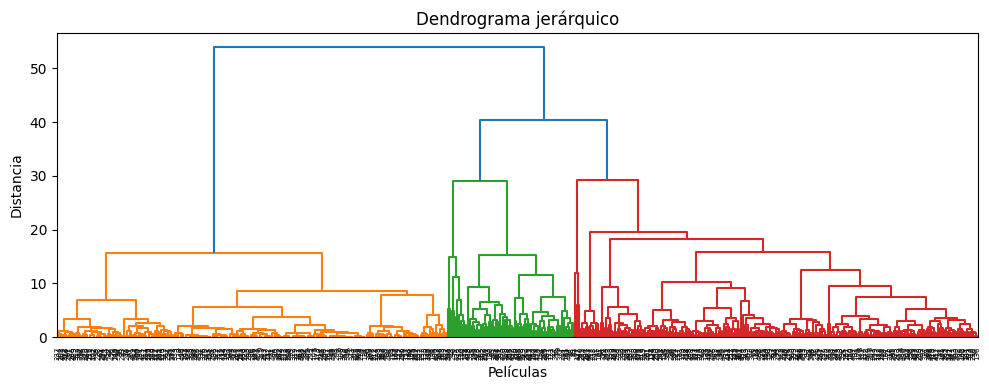

Distribución de clusters jerárquico:
cluster_hier
0    2396
1    8393
2    8585
3     345
Name: count, dtype: int64


In [4]:
K = 4
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X)
df_cluster['cluster_kmeans'] = labels_km

print("Distribución de clusters K-Means:")
print(df_cluster['cluster_kmeans'].value_counts().sort_index())

# Dendrograma con muestra
np.random.seed(123)
idx_dendro = np.random.choice(len(X), 500, replace=False)

plt.figure(figsize=(10, 4))
dendograma = dendrogram(linkage(X[idx_dendro], method='ward'))
plt.title('Dendrograma jerárquico')
plt.xlabel('Películas')
plt.ylabel('Distancia')
plt.tight_layout()
plt.show()

# Clustering jerárquico sobre todo el dataset
hc = AgglomerativeClustering(n_clusters=K, linkage='ward')
labels_hier = hc.fit_predict(X)
df_cluster['cluster_hier'] = labels_hier

print("Distribución de clusters jerárquico:")
print(df_cluster['cluster_hier'].value_counts().sort_index())

### 1.5 Calidad del agrupamiento - Silueta

Silueta K-Means:     0.3729
Silueta Jerárquico:  0.3241


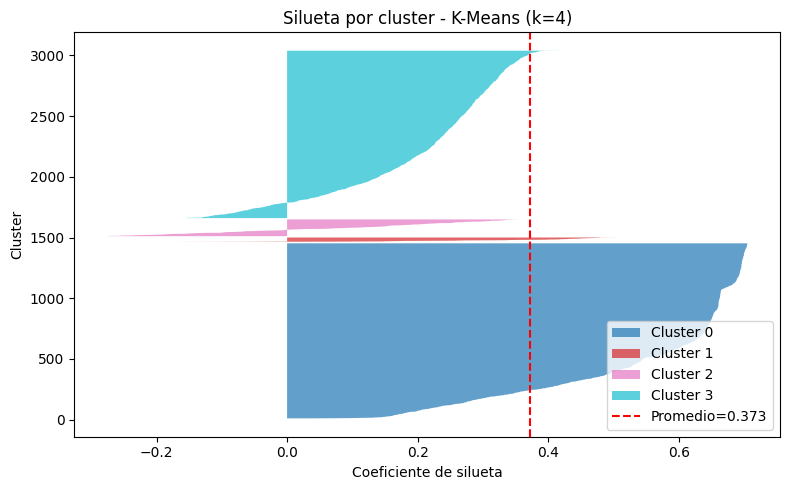

In [5]:
n_sil = 3000
idx_sil = np.random.choice(X.shape[0], n_sil, replace=False)
X_sil = X[idx_sil]
km_sil  = labels_km[idx_sil]
hi_sil  = labels_hier[idx_sil]

sil_km   = silhouette_score(X_sil, km_sil)
sil_hier = silhouette_score(X_sil, hi_sil)
print(f"Silueta K-Means:     {sil_km:.4f}")
print(f"Silueta Jerárquico:  {sil_hier:.4f}")

# Gráfica de silueta por cluster para el mejor modelo
best_labels = km_sil if sil_km >= sil_hier else hi_sil
best_name   = "K-Means" if sil_km >= sil_hier else "Jerárquico"

sil_vals = silhouette_samples(X_sil, best_labels)
fig, ax = plt.subplots(figsize=(8, 5))
y_lower = 10
colors = plt.cm.tab10(np.linspace(0, 1, K))

for i in range(K):
    ith_vals = np.sort(sil_vals[best_labels == i])
    size_i = len(ith_vals)
    y_upper = y_lower + size_i
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_vals,
                     facecolor=colors[i], alpha=0.7, label=f'Cluster {i}')
    y_lower = y_upper + 10

ax.axvline(x=np.mean(sil_vals), color='red', linestyle='--', label=f'Promedio={np.mean(sil_vals):.3f}')
ax.set_xlabel('Coeficiente de silueta')
ax.set_ylabel('Cluster')
ax.set_title(f'Silueta por cluster - {best_name} (k={K})')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

### 1.6 Interpretación de grupos

popularity               budget                   revenue  \
              mean median          mean      median          mean   
cluster                                                             
0             1.71   0.05  1.607325e+04         0.0  2.005539e+04   
1            47.35  22.90  2.640906e+05         0.0  2.537483e+06   
2           167.21  68.61  1.052047e+08  98500000.0  4.118216e+08   
3            38.22  19.30  1.076590e+07         0.0  2.431100e+07   

                     runtime        voteAvg         ...  \
              median    mean median    mean median  ...   
cluster                                             ...   
0                0.0   27.81   10.0    1.00    0.0  ...   
1                0.0   85.32   90.0    6.28    6.5  ...   
2        321562715.0  121.05  118.5    6.90    6.9  ...   
3                0.0  101.49   99.0    6.47    6.5  ...   

        productionCountriesAmount        actorsAmount        castWomenAmount  \
                             mean median         mean median            mean   
cluster                                                                        
0                            0.69    1.0         3.63    3.0            0.52   
1                           11.78    9.0         3.31    2.0            4.69   
2                            1.49    1.0        60.75   53.0           13.93   
3                            1.44    1.0        24.79   20.0            6.50   

               castMenAmount           releaseYear          
        median          mean    median        mean  median  
cluster                                                     
0          0.0        207.45       0.0     2025.00  2025.0  
1          3.0     556096.23  567298.5     2016.99  2018.0  
2         12.0         30.00      26.0     2008.65  2011.0  
3          5.0        498.30      10.0     2008.85  2013.0  

[4 rows x 26 columns]

Cluster 0


,Idioma,Cantidad
0,en,4132
1,es,847
2,fr,796
3,pt,579
4,de,366



Cluster 1


,Idioma,Cantidad
0,en,135
1,es,61
2,ja,32
3,ko,21
4,zh,16



Cluster 2


,Idioma,Cantidad
0,en,844
1,zh,5
2,ja,3
3,fr,2
4,ko,2



Cluster 3


,Idioma,Cantidad
0,en,6743
1,ja,610
2,es,305
3,fr,291
4,ko,145



Cluster 0


,Género,Cantidad
0,Drama,2589
1,Documentary,2124
2,Comedy,1629
3,Horror,890
4,Thriller,745



Cluster 1


,Género,Cantidad
0,Drama,75
1,Comedy,73
2,Romance,49
3,Action,42
4,Horror,40



Cluster 2


,Género,Cantidad
0,Action,415
1,Adventure,396
2,Comedy,272
3,Drama,247
4,Science Fiction,217



Cluster 3


,Género,Cantidad
0,Drama,3627
1,Comedy,2796
2,Thriller,2400
3,Action,2234
4,Horror,1425


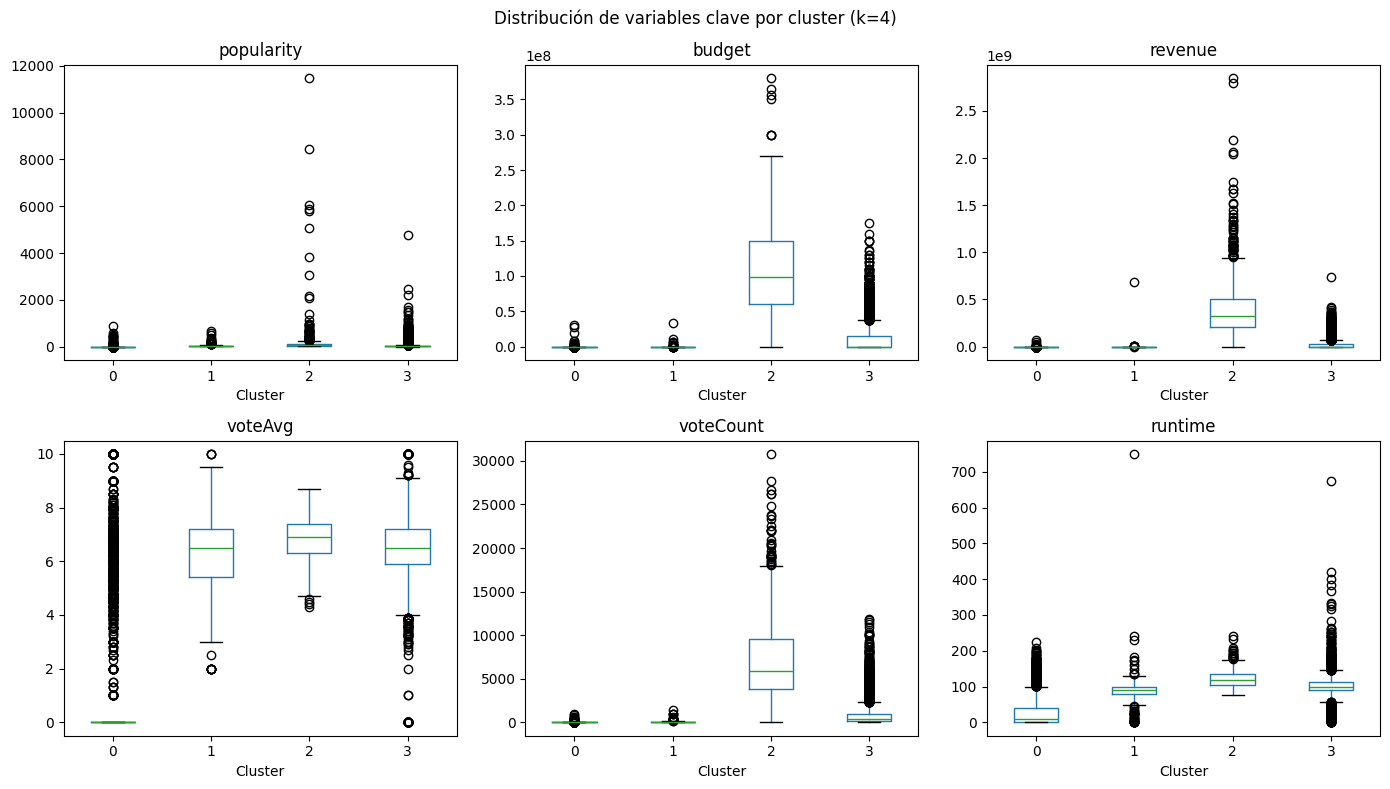

In [6]:
# Alinear índices y asignar mejor modelo
df_full = df.copy()
df_full = df_full.loc[df_cluster.index]
df_full['cluster'] = df_cluster['cluster_kmeans'] if sil_km >= sil_hier else df_cluster['cluster_hier']

resumen = df_full.groupby('cluster')[num_vars].agg(['mean', 'median']).round(2)
display(resumen)

for c in sorted(df_full['cluster'].unique()):
    top_lang = df_full[df_full['cluster']==c]['originalLanguage'].value_counts().head(5).reset_index()
    top_lang.columns = ['Idioma', 'Cantidad']
    print(f'Cluster {c}')
    display(top_lang)
    print()

for c in sorted(df_full['cluster'].unique()):
    genres_series = df_full[df_full['cluster']==c]['genres'].dropna()
    all_genres = genres_series.str.split('|').explode().value_counts().head(5).reset_index()
    all_genres.columns = ['Género', 'Cantidad']
    print(f'Cluster {c}')
    display(all_genres)
    print()

plot_vars = ['popularity', 'budget', 'revenue', 'voteAvg', 'voteCount', 'runtime']
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

for ax, var in zip(axes.flatten(), plot_vars):
    df_full.boxplot(column=var, by='cluster', ax=ax, grid=False)
    ax.set_title(var)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('')

plt.suptitle(f'Distribución de variables clave por cluster (k={K})')
plt.tight_layout()
plt.show()